# AlphaZero FJSP Visualizations

Visualize the heterogeneous graph structure used by the GNN.

In [5]:
import sys
import os
import json
from pathlib import Path

_cwd = Path().resolve()
project_root = None
for parent in [_cwd] + list(_cwd.parents):
    if (parent / "utils" / "input_schemas.py").exists():
        project_root = str(parent)
        break
if project_root is None:
    project_root = "/home/ad.msoe.edu/weinbendera/FJSSP-MCTS-Research"
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

from utils.factory_logic_loader import FactoryLogicLoader
from utils.job_builder import JobBuilder
from utils.input_schemas import ProductRequest
from schedulers.alphazero.env.config_compiler import CompiledConfig
from schedulers.alphazero.env.fjsp_env import FJSPEnv, UNSCHEDULED, IN_PROGRESS, COMPLETED
from schedulers.alphazero.env.graph_builder import GraphBuilder

print(f"Project root: {project_root}")

Project root: C:\Users\weinbendera\Repos\FJSSP Research\FJSSP-MCTS-Research


In [40]:
data_path = os.path.join(project_root, "data", "Input_JSON_Schedule_Optimization.json")
factory_logic = FactoryLogicLoader.load_from_file(data_path)

product_requests = [
    ProductRequest(product='WOVEN LABEL OURELA FABRIC', amount=3, deadline=None),
    ProductRequest(product='ESTORE RIBBON', amount=5, deadline=None),
    # ProductRequest(product='GORGOR\u00c3O RIBBON', amount=3, deadline=None),
    # ProductRequest(product='TAFFETA EMBLEM', amount=3, deadline=None),
    # ProductRequest(product='PRINTED RIBBON', amount=3, deadline=None),
    ProductRequest(product='ROK ELASTIC', amount=3, deadline=None),
    # ProductRequest(product='BRAIDED ELASTIC', amount=3, deadline=None),
    # ProductRequest(product='SMOOTH ELASTIC(A)', amount=3, deadline=None),
    ProductRequest(product='STRAP W/ STRIPES', amount=3, deadline=None),
]

jobs = JobBuilder(factory_logic).build_jobs(product_requests)
config = CompiledConfig.compile(factory_logic, jobs)

print(f"Operations: {config.num_ops}, Jobs: {config.num_jobs}, Machines: {config.num_machines}")
print(f"Action triples: {config.num_actions}")
print(f"Precedence pairs: {config.precedence_pairs.shape[0]}")
print(f"Collision pairs: {config.collision_pairs.shape[0]}")

Operations: 42, Jobs: 14, Machines: 3
Action triples: 96
Precedence pairs: 3
Collision pairs: 1


## FJSP Instance Graph (Initial State)

Shows the full problem structure as the GNN sees it:
- **Operation nodes** (circles) colored by task type
- **Machine nodes** (large blue squares)
- **Eligible edges** (gray): which machines can process each operation
- **Precedence edges** (red arrows): ordering constraints between operations

In [41]:
env = FJSPEnv(config)
env.reset()
graph_builder = GraphBuilder(config)
graph = graph_builder.build(env)

# --- Build networkx graph ---
G = nx.DiGraph()

# Add operation nodes
for op_idx in range(config.num_ops):
    job_idx = int(config.op_to_job[op_idx])
    task_id = config.op_task_ids[op_idx]
    G.add_node(f"op_{op_idx}", node_type="op", job_idx=job_idx, task_id=task_id)

# Add machine nodes
for m_idx in range(config.num_machines):
    G.add_node(f"m_{m_idx}", node_type="machine", label=config.machine_ids[m_idx])

# Add eligible edges (op -> machine)
elig_ei = graph["op", "eligible", "machine"].edge_index.numpy()
for i in range(elig_ei.shape[1]):
    src_op = int(elig_ei[0, i])
    dst_m = int(elig_ei[1, i])
    G.add_edge(f"op_{src_op}", f"m_{dst_m}", edge_type="eligible")

# Add precedence edges (op -> op)
prec_ei = graph["op", "precedes", "op"].edge_index.numpy()
for i in range(prec_ei.shape[1]):
    src = int(prec_ei[0, i])
    dst = int(prec_ei[1, i])
    G.add_edge(f"op_{src}", f"op_{dst}", edge_type="precedes")

print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"  Op nodes: {config.num_ops}, Machine nodes: {config.num_machines}")
print(f"  Eligible edges: {elig_ei.shape[1]}, Precedence edges: {prec_ei.shape[1]}")

Graph: 45 nodes, 99 edges
  Op nodes: 42, Machine nodes: 3
  Eligible edges: 96, Precedence edges: 3


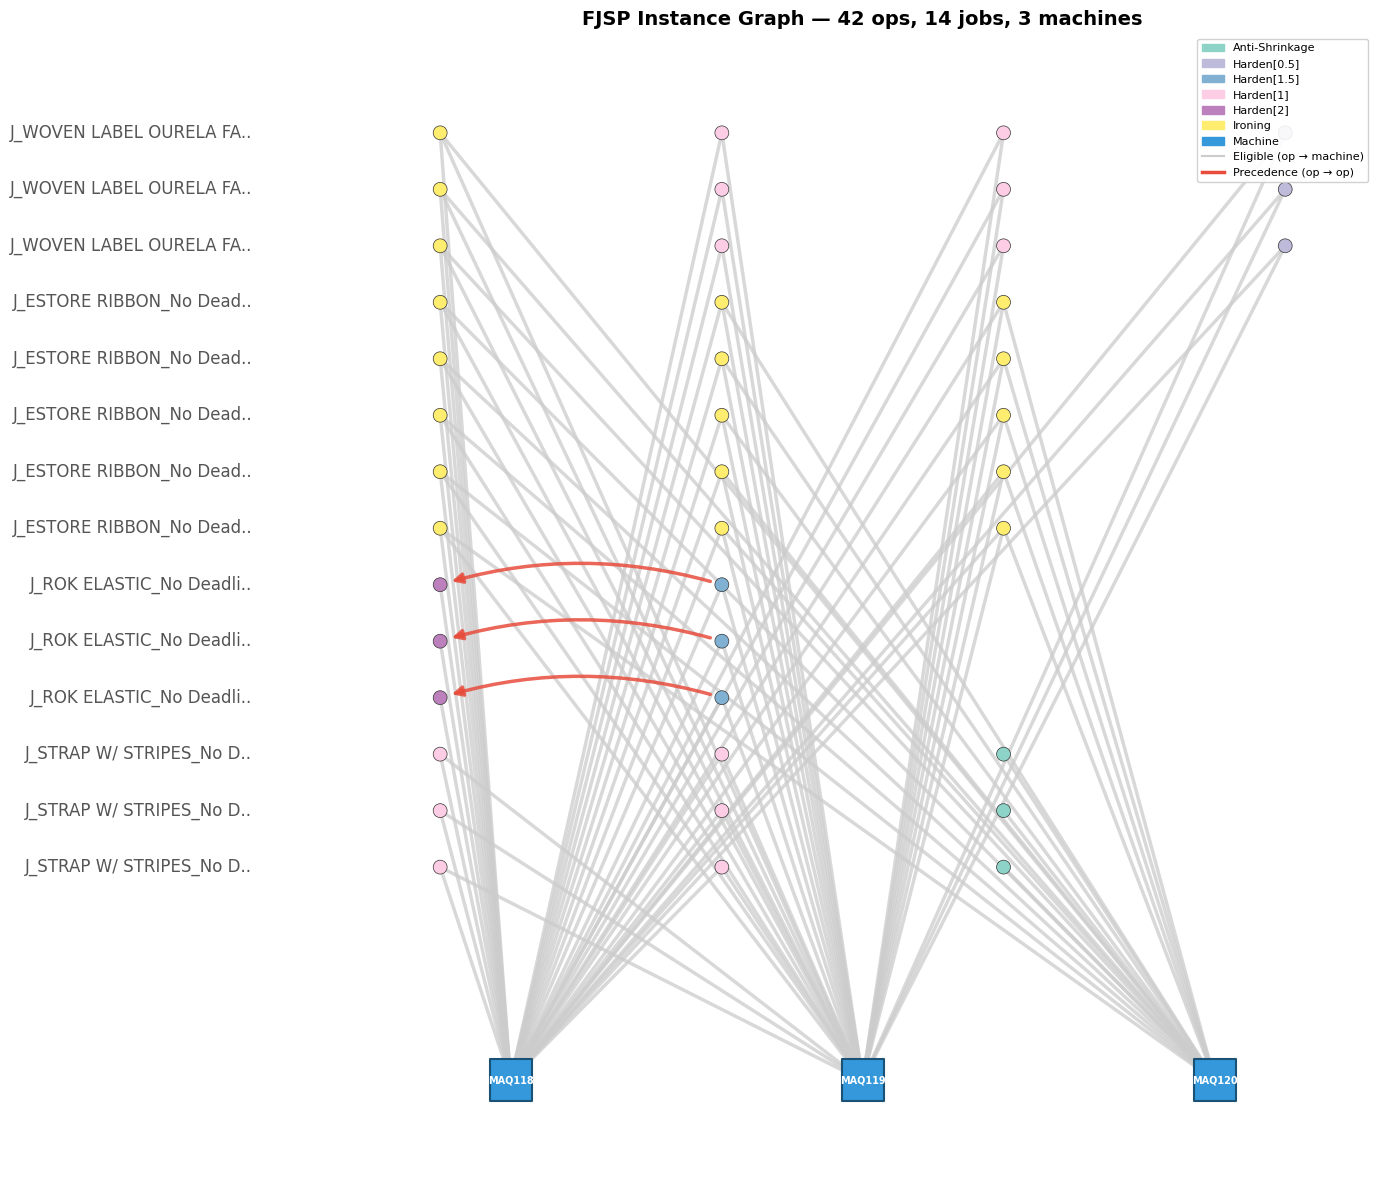

In [42]:
# --- Layout: ops grouped by job in rows, machines at the bottom ---
pos = {}

# Group operations by job
job_ops = {}
for op_idx in range(config.num_ops):
    j = int(config.op_to_job[op_idx])
    job_ops.setdefault(j, []).append(op_idx)

# Color map by task type
unique_tasks = sorted(set(config.op_task_ids))
task_to_color_idx = {t: i for i, t in enumerate(unique_tasks)}
cmap = plt.cm.Set3 if len(unique_tasks) <= 12 else plt.cm.tab20

sorted_jobs = sorted(job_ops.keys())
max_ops_per_job = max(len(ops) for ops in job_ops.values())

x_spacing = 1.2
y_spacing = 0.9

# Place op nodes in a grid: one row per job
for row, job_idx in enumerate(sorted_jobs):
    ops = job_ops[job_idx]
    for col, op_idx in enumerate(ops):
        pos[f"op_{op_idx}"] = (col * x_spacing, -row * y_spacing)

# Place machine nodes below all ops
machine_y = -len(sorted_jobs) * y_spacing - 2.5
machine_x_center = (max_ops_per_job - 1) * x_spacing / 2
machine_spread = max(3.0, max_ops_per_job * x_spacing * 0.6)
for m_idx in range(config.num_machines):
    offset = (m_idx - (config.num_machines - 1) / 2)
    gap = machine_spread / max(config.num_machines - 1, 1)
    pos[f"m_{m_idx}"] = (machine_x_center + offset * gap, machine_y)

# --- Draw ---
fig_h = max(10, len(sorted_jobs) * 0.5 + 5)
fig_w = max(14, max_ops_per_job * 1.5)
fig, ax = plt.subplots(1, 1, figsize=(fig_w, fig_h))

# Eligible edges (thin gray)
eligible_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get("edge_type") == "eligible"]
nx.draw_networkx_edges(
    G, pos, edgelist=eligible_edges, ax=ax,
    edge_color="#CCCCCC", width=2.5, alpha=0.75,
    arrows=False,
)

# Precedence edges (red arrows)
prec_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get("edge_type") == "precedes"]
if prec_edges:
    nx.draw_networkx_edges(
        G, pos, edgelist=prec_edges, ax=ax,
        edge_color="#E74C3C", width=2.5, alpha=0.85,
        arrows=True, arrowsize=15, arrowstyle="-|>",
        connectionstyle="arc3,rad=0.15",
    )

# Operation nodes (colored by task type)
op_nodes = [f"op_{i}" for i in range(config.num_ops)]
op_colors = [
    cmap(task_to_color_idx[config.op_task_ids[i]] / max(len(unique_tasks) - 1, 1))
    for i in range(config.num_ops)
]
nx.draw_networkx_nodes(
    G, pos, nodelist=op_nodes, ax=ax,
    node_color=op_colors, node_size=100,
    edgecolors="#333333", linewidths=0.5,
)

# Machine nodes (large blue squares)
machine_nodes = [f"m_{i}" for i in range(config.num_machines)]
nx.draw_networkx_nodes(
    G, pos, nodelist=machine_nodes, ax=ax,
    node_color="#3498DB", node_size=900,
    node_shape="s", edgecolors="#1A5276", linewidths=1.5,
)

# Machine labels
machine_labels = {f"m_{i}": config.machine_ids[i] for i in range(config.num_machines)}
nx.draw_networkx_labels(
    G, pos, labels=machine_labels, ax=ax,
    font_size=7, font_weight="bold", font_color="white",
)

# Job labels on the left
for row, job_idx in enumerate(sorted_jobs):
    y = -row * y_spacing
    job_id = config.job_ids[job_idx]
    label = job_id if len(job_id) <= 25 else job_id[:23] + ".."
    ax.text(-0.8, y, label, fontsize=12, ha="right", va="center", color="#555555")

# --- Legend ---
legend_handles = []
for task_id in unique_tasks:
    color = cmap(task_to_color_idx[task_id] / max(len(unique_tasks) - 1, 1))
    legend_handles.append(mpatches.Patch(color=color, label=task_id))
legend_handles.append(mpatches.Patch(color="#3498DB", label="Machine"))
legend_handles.append(Line2D([0], [0], color="#CCCCCC", linewidth=1.5, label="Eligible (op \u2192 machine)"))
legend_handles.append(Line2D([0], [0], color="#E74C3C", linewidth=2.5, label="Precedence (op \u2192 op)"))

ax.legend(handles=legend_handles, loc="upper right", fontsize=8, framealpha=0.9)
ax.set_title(
    f"FJSP Instance Graph \u2014 {config.num_ops} ops, {config.num_jobs} jobs, {config.num_machines} machines",
    fontsize=14, fontweight="bold",
)
ax.axis("off")
plt.tight_layout()
plt.show()